In [1]:
import sys
from pathlib import Path
import warnings

import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

sys.path.append('../')
from src.dataset import get_forecast_df
from src.constants import target_column_list, Columns
from src.forecast_util import mape, LogConverter

plt.style.use('ggplot')
warnings.filterwarnings('ignore')

In [2]:
train_df, _, _ = get_forecast_df('../data/')

In [19]:
# データのほとんどが0である(1日単位でデータを作成する際に、取得できなかった日付のトレンドは0埋めしているとか？)。
display(train_df.describe())
for target_column in target_column_list:
    print(f'{target_column} ...')
    print(f'{len(train_df[train_df[target_column] != 0])} / {len(train_df)}')
    print(f'not 0 trends percentage: {len(train_df[train_df[target_column] != 0]) / len(train_df) * 100:.2f} %')

,TensorFlow: (日本),PyTorch: (日本),Keras: (日本),Caffe: (日本),Deeplearning4j: (日本)
count,2508.000000,2508.000000,2508.000000,2508.000000,2508.000000
mean,8.757974,7.454545,6.910287,5.900718,5.420654
std,16.151952,15.558116,14.854363,13.604744,13.075632
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,16.000000,0.000000,0.000000,0.000000,0.000000
max,100.000000,100.000000,100.000000,100.000000,100.000000


TensorFlow: (日本) ...
723 / 2508
not 0 trends percentage: 28.83 %
PyTorch: (日本) ...
614 / 2508
not 0 trends percentage: 24.48 %
Keras: (日本) ...
563 / 2508
not 0 trends percentage: 22.45 %
Caffe: (日本) ...
497 / 2508
not 0 trends percentage: 19.82 %
Deeplearning4j: (日本) ...
459 / 2508
not 0 trends percentage: 18.30 %


## プロット

### 系列の推移をプロット

#### そのままプロット

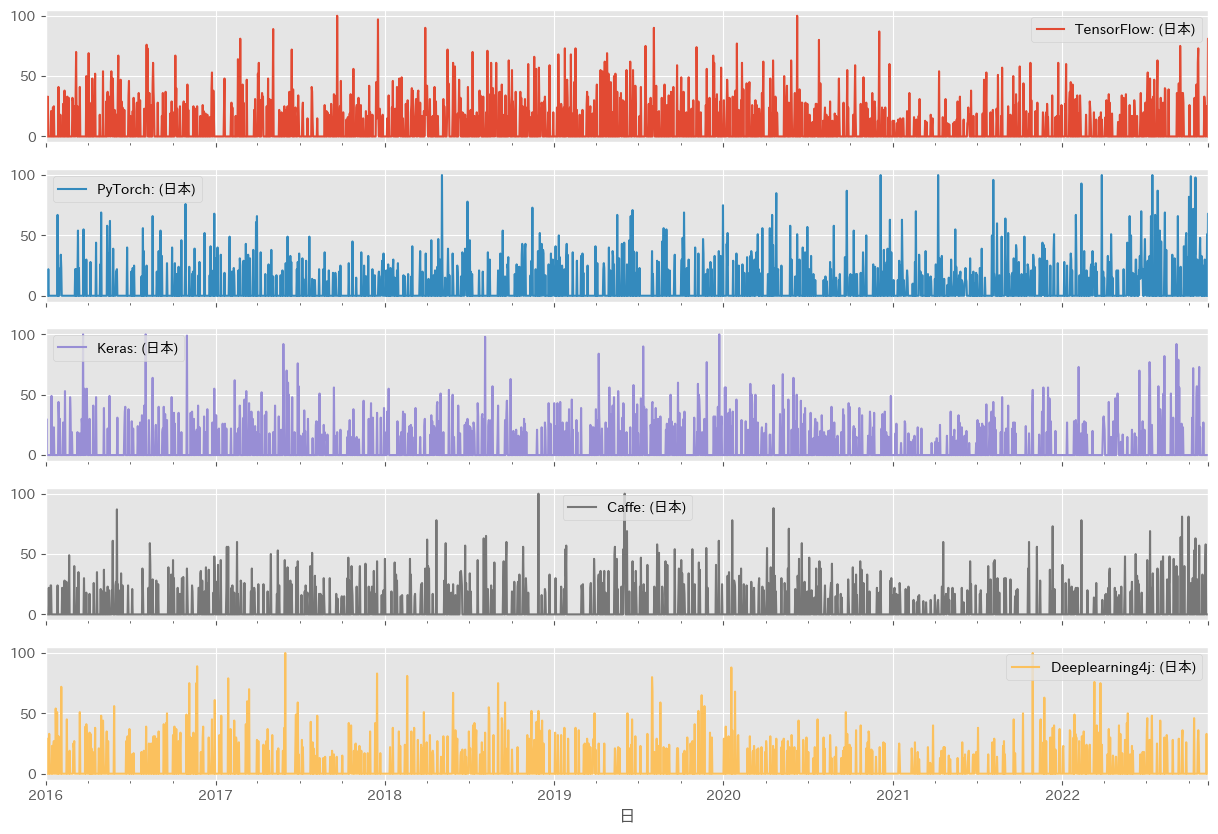

In [21]:
figsize = (15, 10)
plot_df = train_df.set_index(Columns.date)
_ = plot_df[target_column_list].plot(subplots=True, figsize=figsize)
plt.legend()
plt.show()

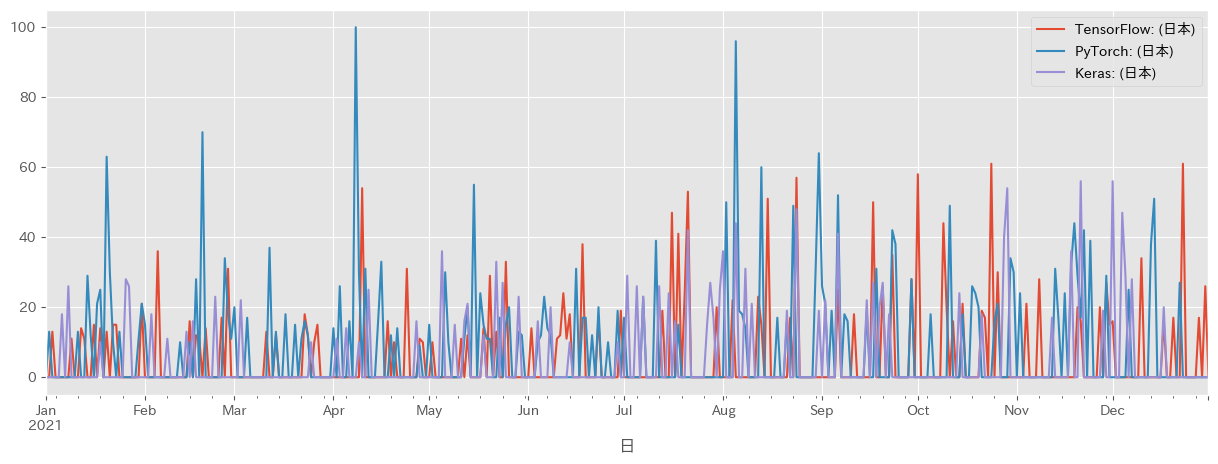

In [23]:
# 1年分のデータをプロット
figsize = (15, 5)
_ = plot_df[[Columns.tensorflow, Columns.pytorch, Columns.keras]]['2021-01-01':'2021-12-31'].plot(figsize=figsize)
plt.legend()
plt.show()

#### 移動平均のプロット(100日の移動平均)

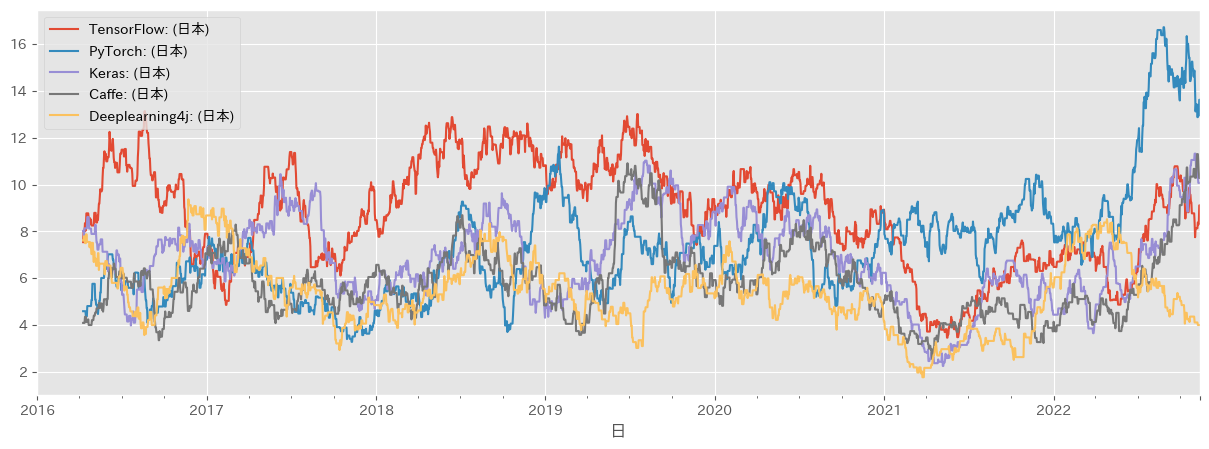

In [5]:
window_size = 100
figsize = (15, 5)
plot_df = train_df.set_index(Columns.date)
plot_df[target_column_list].rolling(window=window_size).mean().plot(figsize=figsize)
plt.show()

### 総ダウンロード数の推移

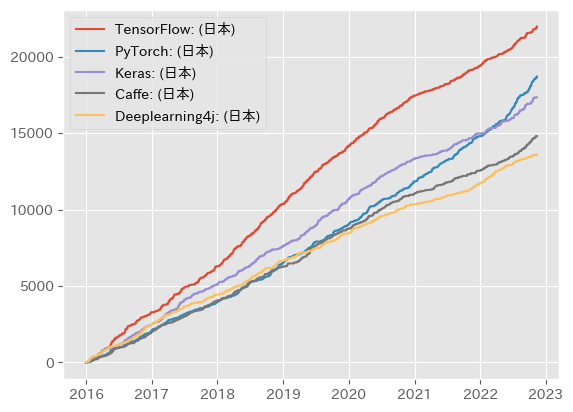

In [6]:
for target_column in target_column_list:
    plt.plot(np.cumsum(plot_df[target_column]), label=target_column)
plt.legend()
plt.show()

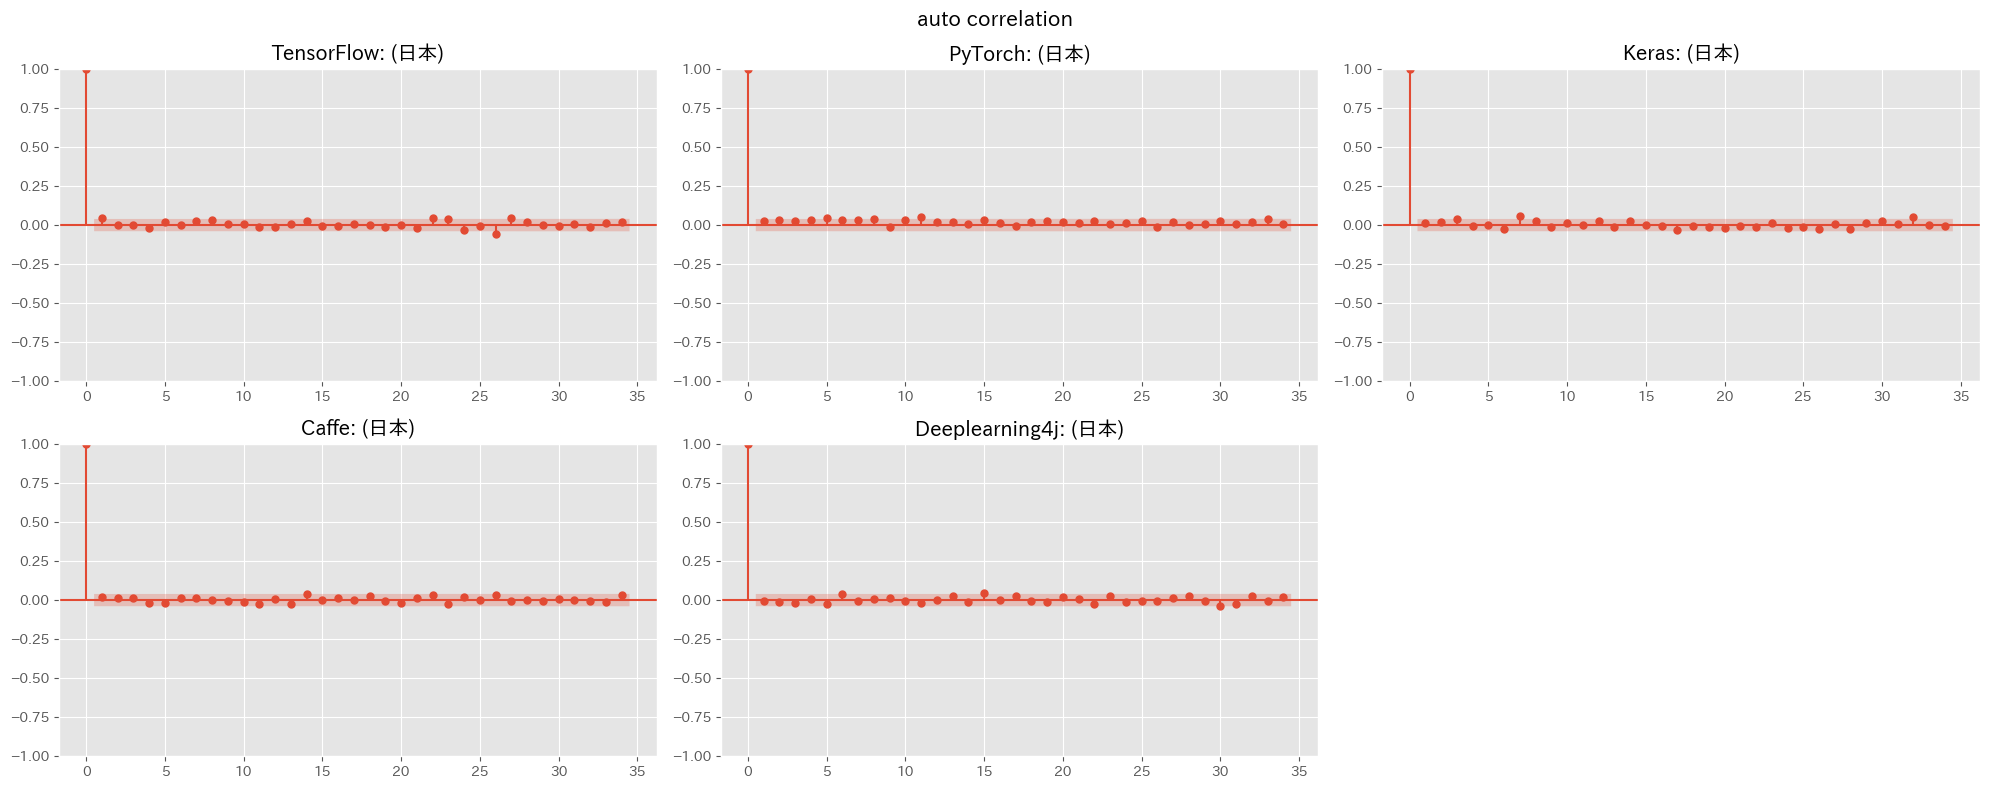

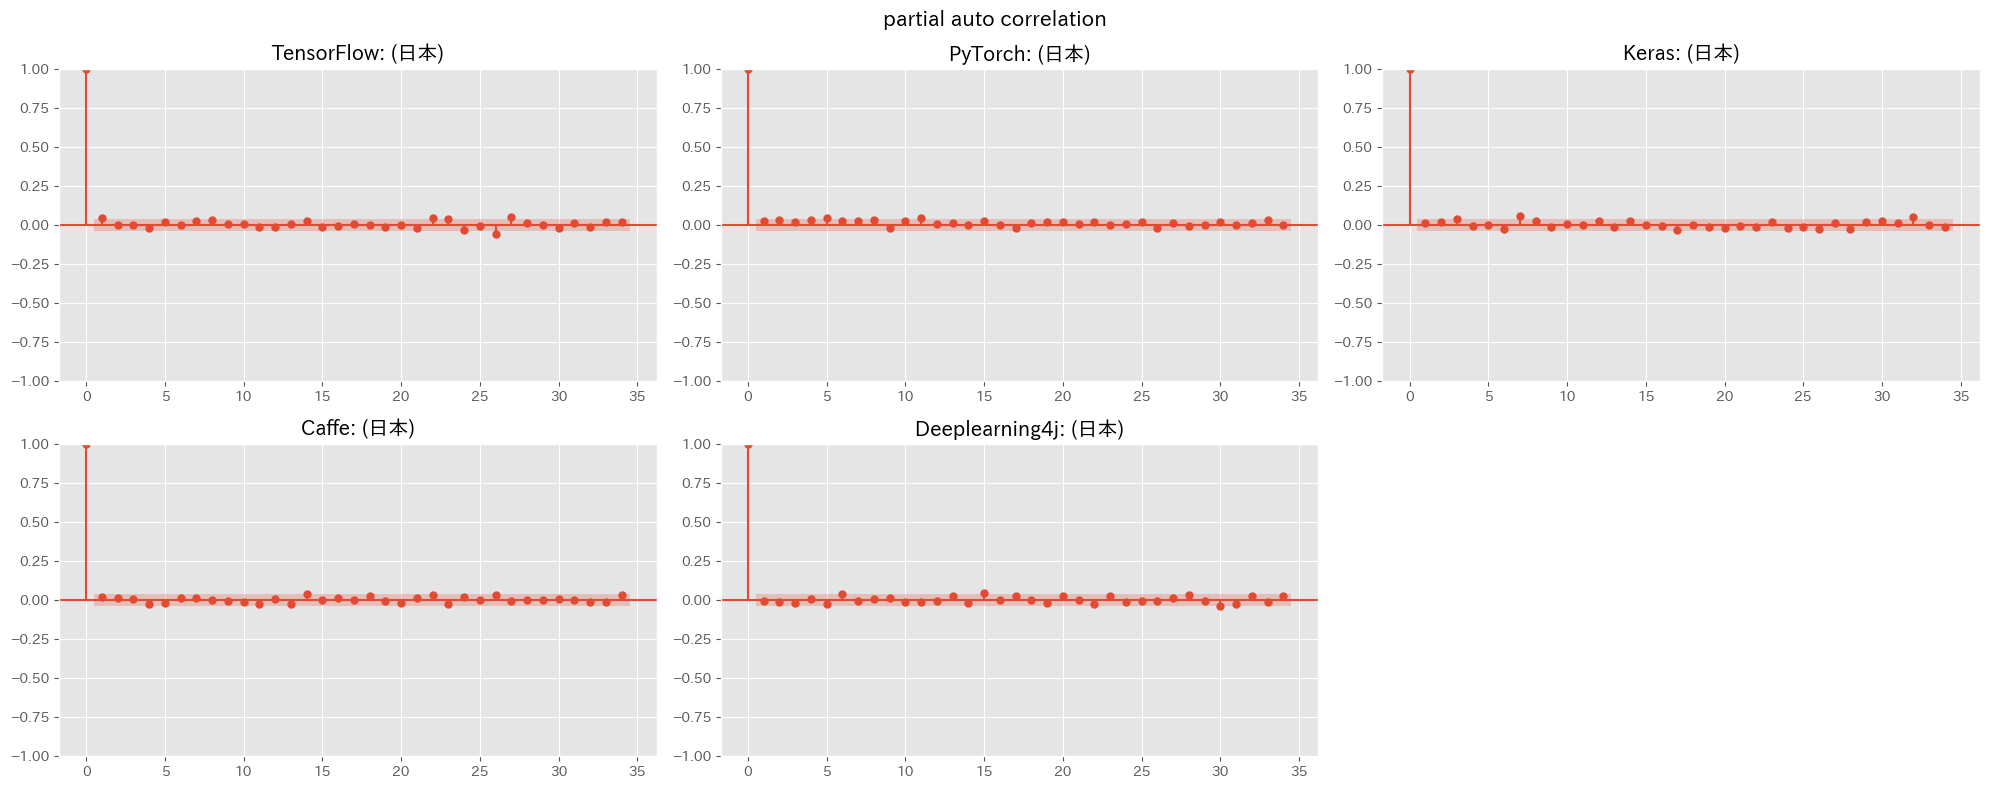

In [7]:
plot_column_list = [Columns.tensorflow, Columns.pytorch, Columns.keras, Columns.caffe, Columns.deeplearning4j]
# 自己相関
ncols = 3
nrows = 2
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(20, 8))
for i, target_column in enumerate(target_column_list):
    col, row = i % ncols, i // ncols
    ax = axes[row, col]
    plot_acf(x=plot_df[target_column], ax=ax)
    ax.set_title(target_column)
axes[-1, -1].axis('off')
plt.suptitle('auto correlation', fontsize=15)
fig.tight_layout()
plt.show()

# 偏自己相関
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(20, 8))
for i, target_column in enumerate(target_column_list):
    col, row = i % ncols, i // ncols
    ax = axes[row, col]
    plot_pacf(x=plot_df[target_column], ax=ax)
    ax.set_title(target_column)
axes[-1, -1].axis('off')
plt.suptitle('partial auto correlation', fontsize=15)
fig.tight_layout()
plt.show()

## トレンド(1年のうち、〜月に検索が多いとか)の確認

* 7, 8月に検索数が多くなる場合が多い(お盆休みとかで個人開発したりしてるとか？)

In [26]:
def plot_trends_per_year(df, target_column, figsize=(15, 3)):
    for y in df['year'].unique():
        target_df = df[df['year'] == y].copy()
        target_df.sort_values(Columns.date, inplace=True)
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=figsize)
        target_df.groupby('day').mean()[target_column]\
            .plot(kind='line',
                  title='average terends: day',
                  lw=2,
                  ax=ax1)

        target_df.groupby('month').mean()[target_column] \
            .plot(kind='line',
                  title='average terends: month',
                  lw=2,
                  ax=ax2)

        target_df.groupby('weekday').mean()[target_column] \
            .plot(kind='line',
                  lw=2,
                  title='average terends: weekday',
                  ax=ax3)

        fig.suptitle('Trends for year: {0}'.format(y),
                     size=20,
                     y=1.1)
        plt.tight_layout()
        plt.show()

In [27]:
train_df['month'] = train_df[Columns.date].dt.month
train_df['year'] = train_df[Columns.date].dt.year
train_df['day'] = train_df[Columns.date].dt.day
train_df['weekday'] = train_df[Columns.date].dt.dayofweek

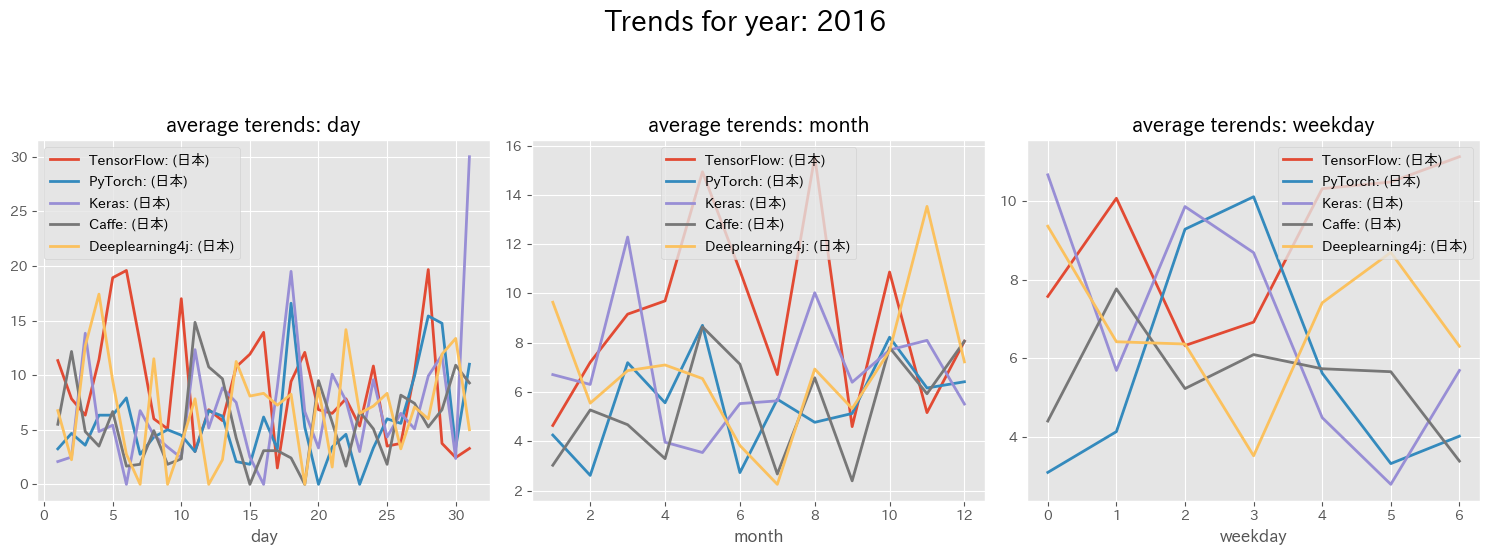

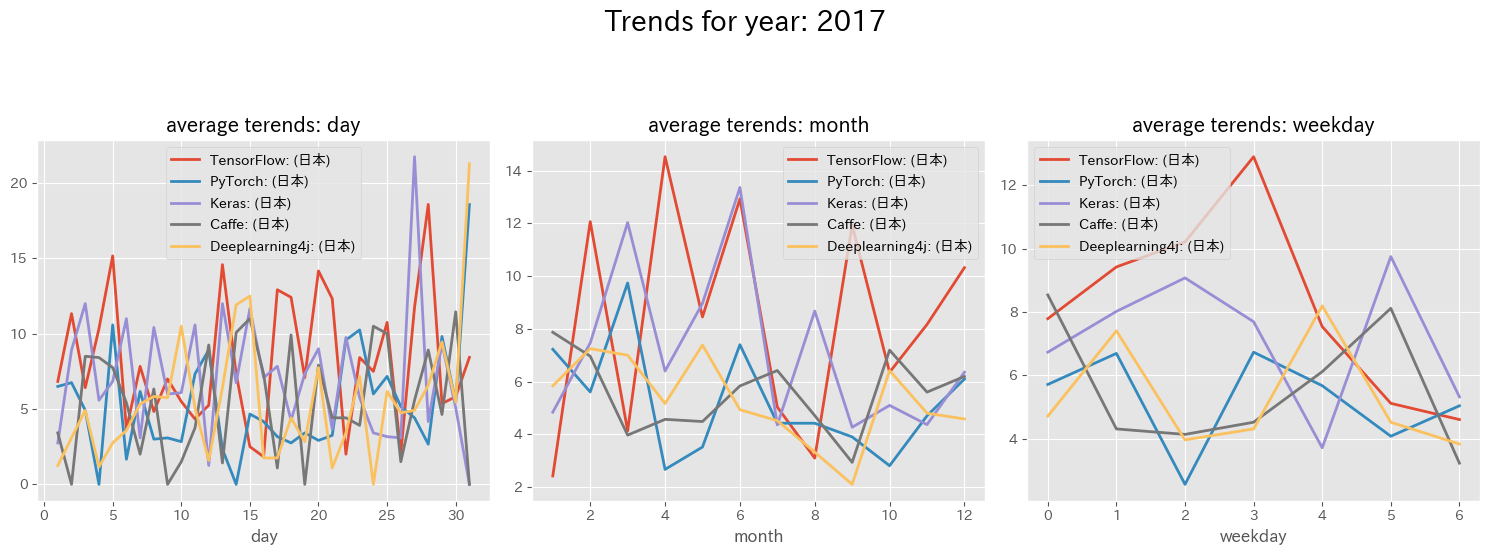

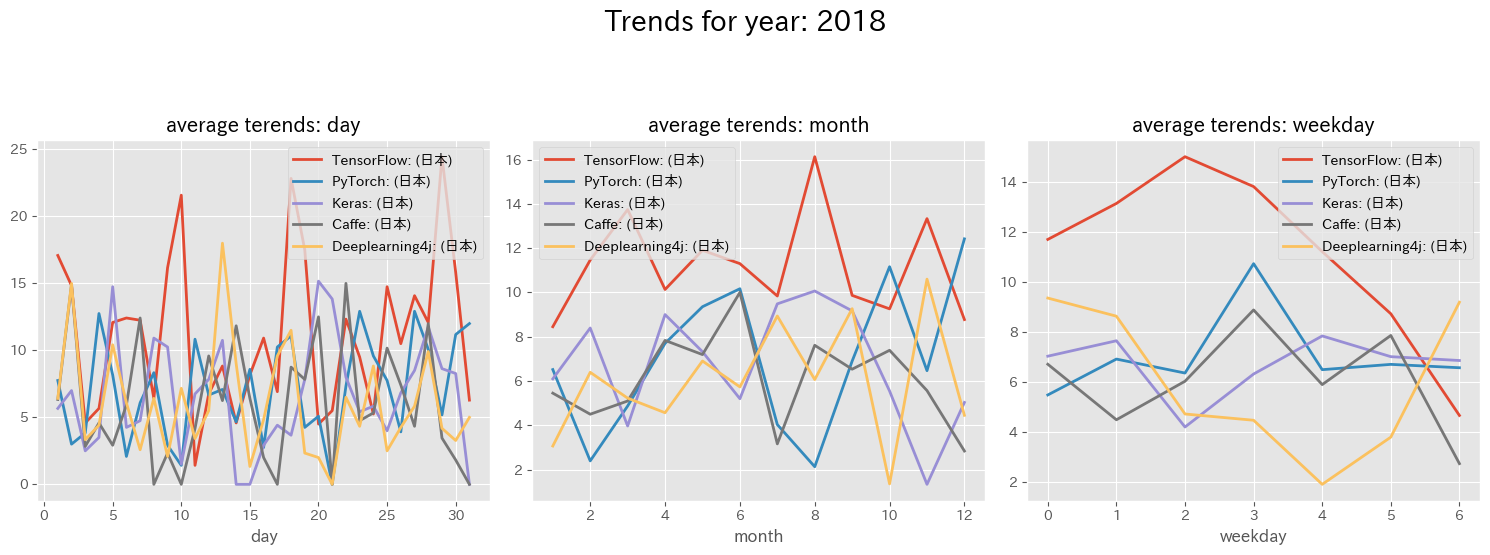

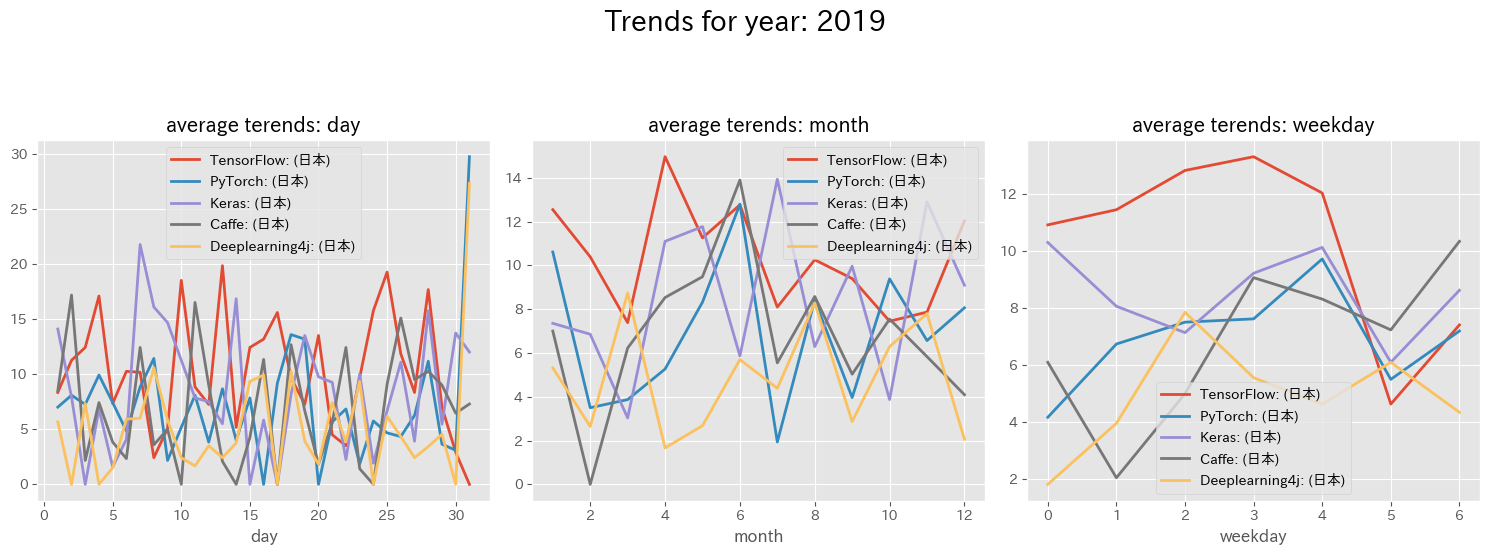

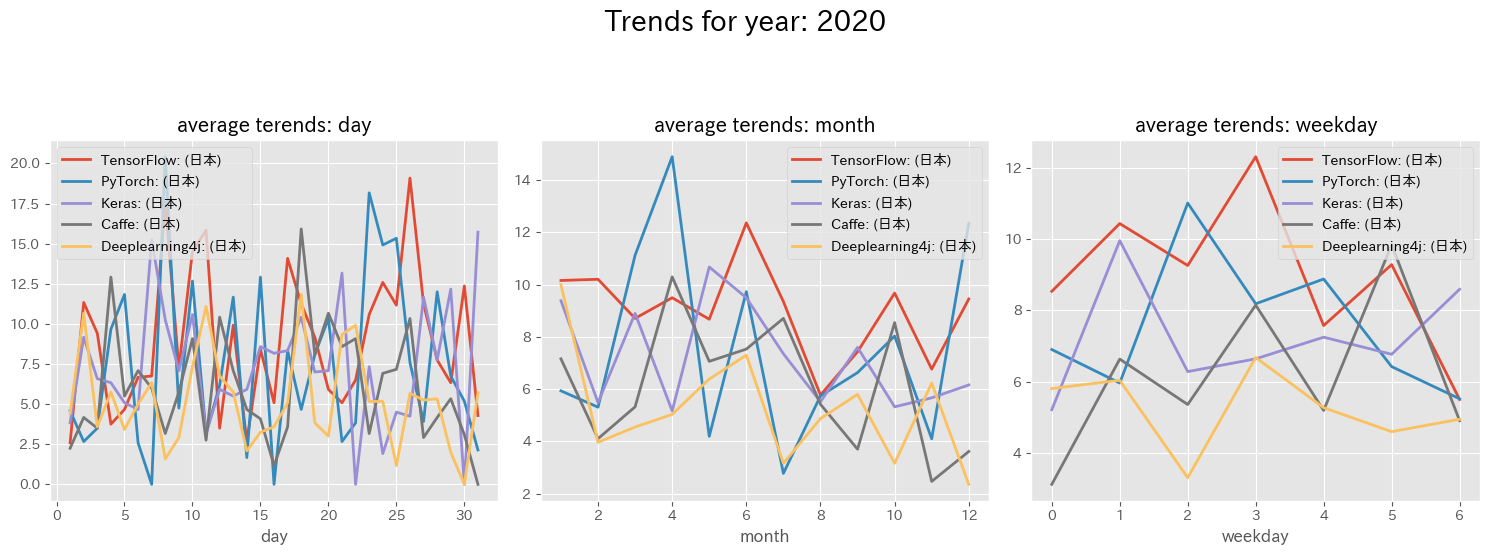

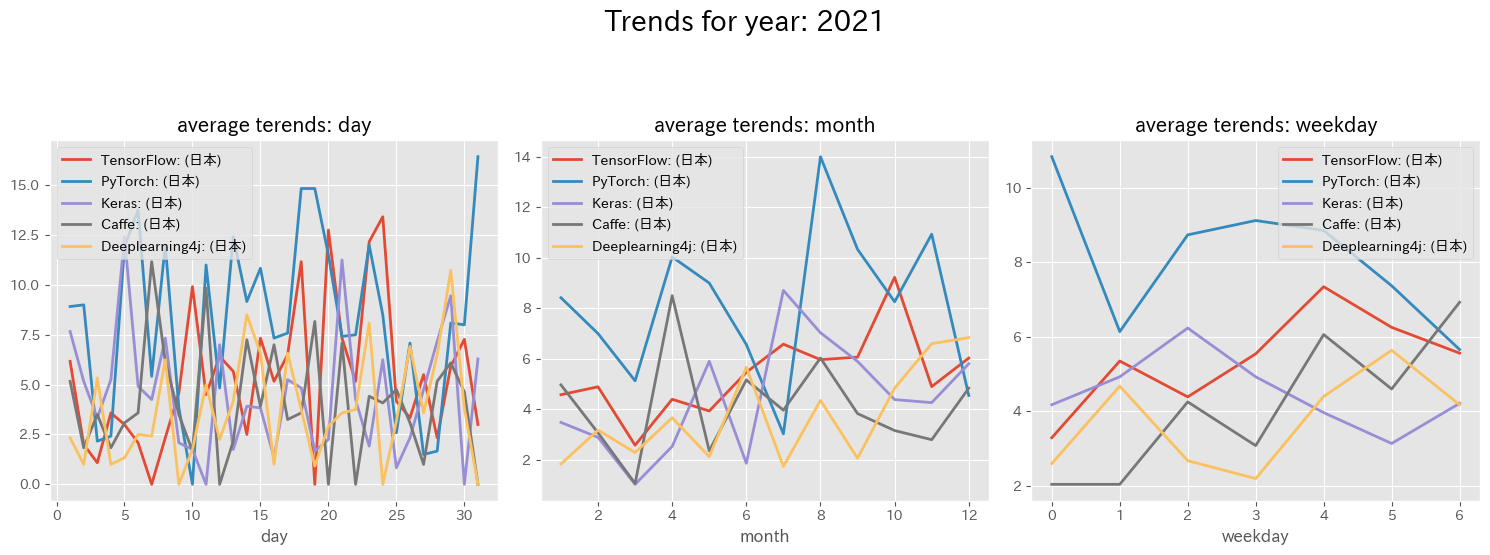

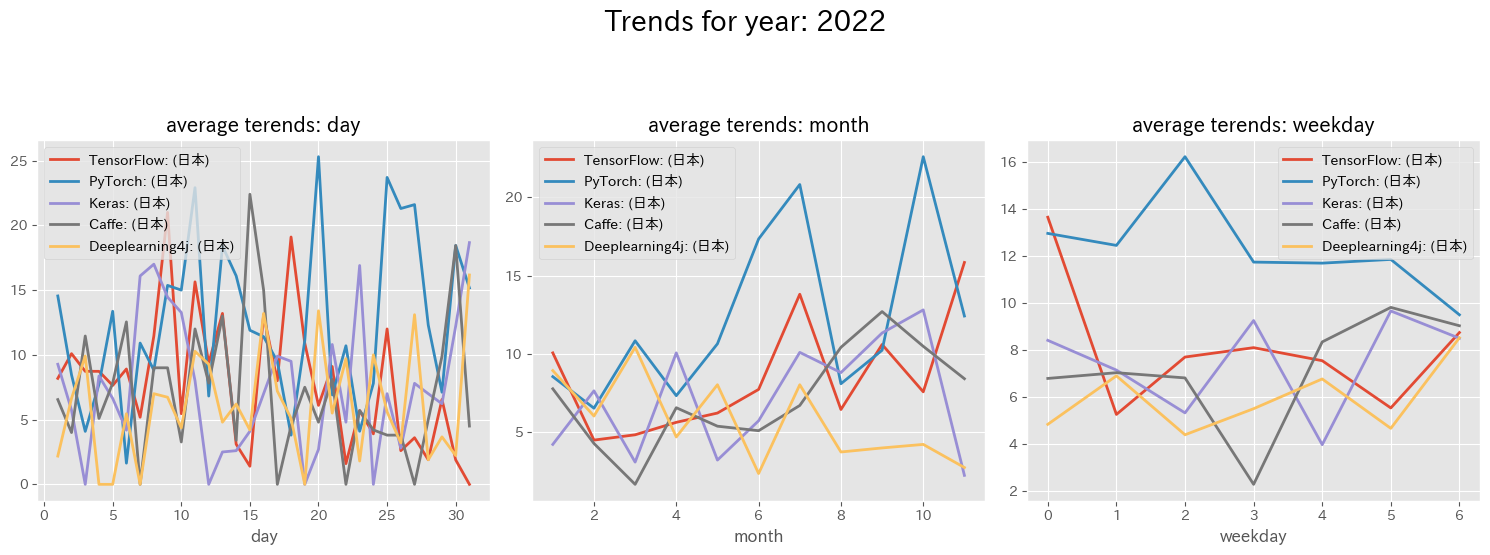

In [28]:
plot_trends_per_year(train_df, target_column_list, figsize=(15, 5))